In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.nasnet import NASNetLarge,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height, channels = (331,331,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(331, 331))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 331, 331, 3)

In [5]:
# Creating base_model
image_shape = (331, 331, 3)                                                                                                                                                                                                                                                                                            
base_model = NASNetLarge(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(10136, 4032)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(10136, 4032)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [ ]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 44.8min


[CV] .............. gamma=1e-07, C=0.01, score=0.137795, total=28.1min
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.136986, total=28.2min
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.138477, total=28.2min
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.137695, total=28.2min
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.139165, total=28.1min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.139442, total=28.2min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.137795, total=28.2min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 60.2min


[CV] .............. gamma=1e-07, C=0.01, score=0.138751, total=37.1min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.139442, total=36.4min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.137255, total=36.7min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.137695, total=36.7min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.137695, total=36.7min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.136986, total=36.9min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.137255, total=36.7min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 61.6min


[CV] gamma=0.0001, C=0.01 ............................................
[CV] ................ gamma=10.0, C=0.1, score=0.299805, total=38.1min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................. gamma=1.0, C=0.1, score=0.479125, total=38.0min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................ gamma=10.0, C=0.1, score=0.300391, total=37.8min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.136986, total=34.7min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.137695, total=35.6min
[CV] gamma=1e-07, C=1.0 ..............................................


[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 448.2min


[CV] ............... gamma=1e-08, C=1.0, score=0.137795, total=35.0min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.137255, total=34.7min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................ gamma=10.0, C=0.1, score=0.292157, total=47.8min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] ................ gamma=10.0, C=0.1, score=0.274606, total=47.9min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.137795, total=27.0min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] ................ gamma=10.0, C=0.1, score=0.302579, total=47.4min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.138477, total=27.5min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 498.5min


[CV] ............... gamma=1e-06, C=1.0, score=0.137795, total=27.3min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-06, C=1.0, score=0.139442, total=27.6min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-05, C=1.0, score=0.137695, total=27.7min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-07, C=1.0, score=0.139165, total=35.6min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-07, C=1.0, score=0.138751, total=34.6min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-05, C=1.0, score=0.137255, total=28.4min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-07, C=1.0, score=0.138889, total=35.3min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 539.0min


[CV] ............... gamma=0.001, C=1.0, score=0.658203, total=16.8min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=0.001, C=1.0, score=0.680039, total=16.9min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] .............. gamma=0.0001, C=1.0, score=0.333008, total=25.8min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ................ gamma=0.01, C=1.0, score=0.820588, total= 8.7min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=0.001, C=1.0, score=0.661417, total=16.7min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=0.001, C=1.0, score=0.656496, total=16.7min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ................ gamma=0.01, C=1.0, score=0.804688, total=11.0min
[CV] gamma=0.1, C=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 560.2min


[CV] ................ gamma=0.01, C=1.0, score=0.833499, total= 8.9min
[CV] gamma=1.0, C=1.0 ................................................
[CV] ................ gamma=0.01, C=1.0, score=0.824405, total= 8.8min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] .............. gamma=0.0001, C=1.0, score=0.347610, total=32.1min
[CV] ................ gamma=0.01, C=1.0, score=0.829026, total= 8.8min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................ gamma=0.01, C=1.0, score=0.822709, total= 8.9min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................. gamma=0.1, C=1.0, score=0.873777, total= 8.8min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................. gamma=0.1, C=1.0, score=0.876969, total= 8.6min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 609.1min


[CV] ................ gamma=10.0, C=1.0, score=0.410784, total=41.0min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.386811, total=40.6min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.414062, total=41.2min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.408465, total=40.8min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.395648, total=40.5min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.435516, total=40.9min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.422701, total=43.8min
[CV] gamma=1e-06, C=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 669.9min


[CV] .............. gamma=1e-07, C=10.0, score=0.138751, total=30.0min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-07, C=10.0, score=0.139165, total=29.4min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-07, C=10.0, score=0.139442, total=29.6min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.137255, total=30.4min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.136986, total=34.2min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.137695, total=34.7min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.137795, total=34.1min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 713.1min


[CV] .............. gamma=1e-05, C=10.0, score=0.336310, total=28.3min
[CV] gamma=0.01, C=10.0 ..............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.662710, total=18.0min
[CV] gamma=0.01, C=10.0 ..............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.683845, total=18.3min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] .............. gamma=1e-05, C=10.0, score=0.338966, total=28.9min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.674603, total=18.4min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] .............. gamma=1e-05, C=10.0, score=0.347610, total=29.9min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.680915, total=18.5min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 738.0min


[CV] ................ gamma=0.1, C=10.0, score=0.909804, total=10.9min
[CV] gamma=10.0, C=10.0 ..............................................
[CV] ................ gamma=0.1, C=10.0, score=0.916339, total=11.1min
[CV] gamma=10.0, C=10.0 ..............................................
[CV] ................ gamma=0.1, C=10.0, score=0.913947, total=10.8min
[CV] gamma=10.0, C=10.0 ..............................................
[CV] ................ gamma=0.1, C=10.0, score=0.912698, total=10.0min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] ................ gamma=0.1, C=10.0, score=0.894945, total=10.1min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] ................ gamma=0.1, C=10.0, score=0.896414, total= 9.8min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] ................ gamma=0.1, C=10.0, score=0.909543, total=11.3min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 806.3min


[CV] ............... gamma=10.0, C=10.0, score=0.463221, total=47.5min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............... gamma=10.0, C=10.0, score=0.439243, total=47.8min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.138477, total=28.7min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.137795, total=29.7min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.138751, total=29.6min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.138889, total=29.3min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.139165, total=28.8min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 856.6min


[CV] ............ gamma=0.0001, C=100.0, score=0.803711, total= 8.7min
[CV] gamma=0.001, C=100.0 ............................................
[CV] ............ gamma=0.0001, C=100.0, score=0.827789, total= 8.6min
[CV] gamma=0.001, C=100.0 ............................................
[CV] ............. gamma=1e-06, C=100.0, score=0.338966, total=25.8min
[CV] gamma=0.001, C=100.0 ............................................
[CV] ............. gamma=1e-06, C=100.0, score=0.347610, total=25.6min
[CV] gamma=0.01, C=100.0 .............................................
[CV] ............ gamma=0.0001, C=100.0, score=0.822549, total= 8.6min
[CV] gamma=0.01, C=100.0 .............................................
[CV] ............. gamma=0.001, C=100.0, score=0.883789, total= 5.4min
[CV] gamma=0.01, C=100.0 .............................................
[CV] ............. gamma=0.001, C=100.0, score=0.878431, total= 5.4min
[CV] gamma=0.01, C=100.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 877.8min


[CV] .............. gamma=0.01, C=100.0, score=0.922849, total= 5.5min
[CV] gamma=1.0, C=100.0 ..............................................
[CV] .............. gamma=0.01, C=100.0, score=0.915354, total= 5.5min
[CV] gamma=1.0, C=100.0 ..............................................
[CV] .............. gamma=0.01, C=100.0, score=0.906838, total= 5.4min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .............. gamma=0.01, C=100.0, score=0.912698, total= 5.4min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .............. gamma=0.01, C=100.0, score=0.915507, total= 5.4min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .............. gamma=0.01, C=100.0, score=0.898406, total= 5.5min
[CV] gamma=10.0, C=100.0 .............................................
[CV] ............... gamma=0.1, C=100.0, score=0.892578, total= 8.9min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 940.2min


[CV] .............. gamma=10.0, C=100.0, score=0.422244, total=38.9min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] ............ gamma=1e-08, C=1000.0, score=0.137795, total=31.1min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.419387, total=39.1min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.450397, total=38.9min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.463221, total=39.0min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.439243, total=41.9min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.433102, total=42.6min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 986.2min


[CV] ........... gamma=0.0001, C=1000.0, score=0.880859, total= 5.3min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.344896, total=28.6min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.338966, total=28.7min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.347610, total=28.8min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.336310, total=29.1min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-05, C=1000.0, score=0.825915, total= 9.9min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ........... gamma=0.0001, C=1000.0, score=0.879412, total= 6.0min
[CV] gamma=0.01, C=1000.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 1060.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01]), 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [ ]:
top_model.cv_results_

{'mean_fit_time': array([1720.23073165, 1850.91591854, 1702.5645056 , 1700.65528255,
        1982.51991518, 1525.76975331, 1979.34224744, 1452.58526137,
        1943.80555065, 2740.06883228, 1808.02679899, 1675.25606105,
        1805.61378963, 1739.1778012 , 1771.61560299, 1620.70881965,
        1019.74757755,  910.41575434, 1811.57498798, 2630.99584217,
        1691.59478045, 1712.8010026 , 1862.61540315, 1652.77576292,
        1606.79780374, 1023.59395771,  466.64294107,  520.00466473,
        1858.40540955, 2401.27066252, 1726.2101002 , 1696.41961725,
        1854.28563313, 1599.98834257,  997.69975412,  498.12679009,
         310.7117511 ,  555.4632901 , 1878.99223628, 2648.89368773,
        1658.50507739, 1746.59126048, 1619.55788722,  904.13686757,
         458.36941459,  283.01498895,  265.1072758 ,  492.81012707,
        1726.37273946, 2343.8124804 , 1613.09023433, 1527.27325051,
         906.96992049,  456.9358856 ,  277.80534251,  273.4780889 ,
         280.84884048,  534.680

In [ ]:
top_model.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00079, params: {'gamma': 1e-08, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-07, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-06, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-05, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 0.0001, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 0.001, 'C': 0.01},
 mean: 0.32922, std: 0.00804, params: {'gamma': 0.01, 'C': 0.01},
 mean: 0.42640, std: 0.00995, params: {'gamma': 0.1, 'C': 0.01},
 mean: 0.33741, std: 0.01077, params: {'gamma': 1.0, 'C': 0.01},
 mean: 0.16900, std: 0.00366, params: {'gamma': 10.0, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-08, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-07, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-06, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-05, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 0.0001, 'C': 0.1},
 mea

In [ ]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'gamma': 0.01, 'C': 1000.0} - score: 0.9110


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


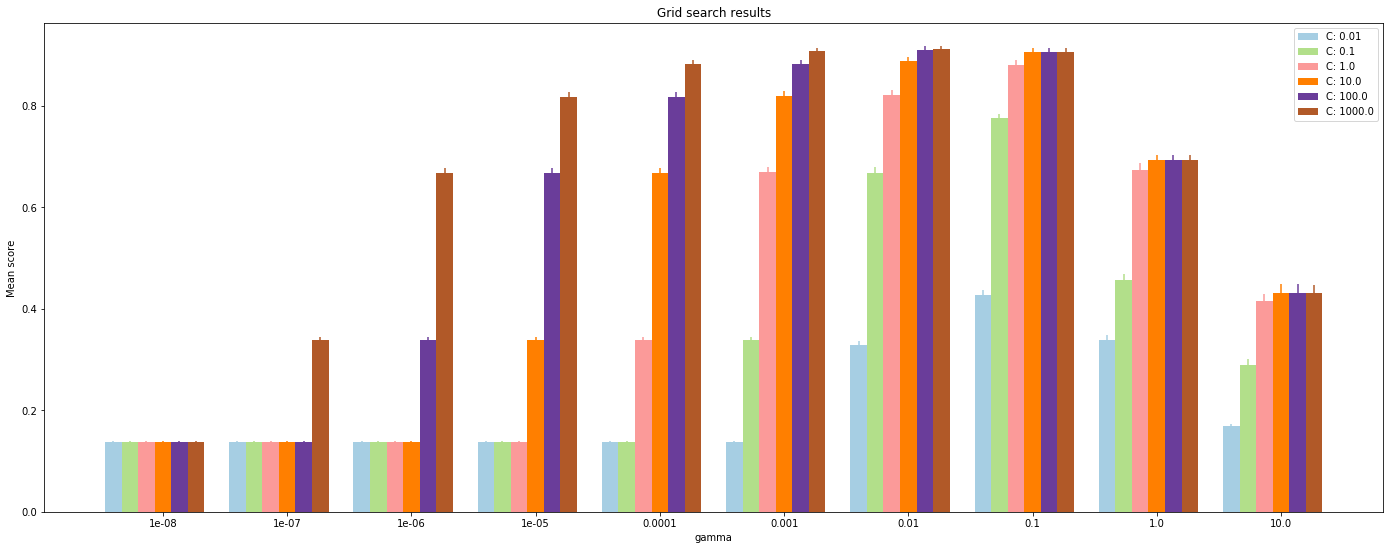

In [ ]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()